🏗️ DDPM from Scratch
====

In [2]:
import torch
import torch.nn as nn
import numpy as np

![DDPM Algorithms](ddpm-algorithms.png)

In [2]:
class DiffusionProcess():
    def __init__(
        self,
        num_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        """
        Initialize the diffusion process with a linear schedule for betas.

        Args:
            num_timesteps (int): Number of timesteps in the diffusion process.
            beta_start (float): Initial value of beta.
            beta_end (float): Final value of beta.
        """
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - self.alpha_bars)

    def add_noise(
            self,
            x_start: torch.Tensor,
            t: torch.Tensor,
        ):
        """
        Forward diffusion process.
        Returns:
            x_t: Noisy image at timestep t.
            noise: Noise added to the original image.
        """
        if t < 0 or t >= self.num_timesteps:
            raise ValueError(f"t must be in [0, {self.num_timesteps - 1}]")
        noise = torch.randn_like(x_start)
        x_t = (
            self.sqrt_alpha_bars[t] * x_start +
            self.sqrt_one_minus_alpha_bars[t] * noise
        )
        return x_t, noise
    
    def sample_prev_timestep(
            self,
            x_t: torch.Tensor,
            noise_pred: torch.Tensor,
            t: torch.Tensor,
        ):
        """
        Reverse diffusion process.
        Returns:
            x_t_minus_1: Sampled image at timestep t-1.
        """
        # mean of x_t-1
        coef = self.betas[t] / self.sqrt_one_minus_alpha_bars[t]
        mean = (x_t - coef * noise_pred) / self.sqrt_alpha_bars[t]

        if t == 0:
            return mean
        # variance of x_t-1
        variance = self.betas[t] * (1 - self.alpha_bars[t - 1]) / (1 - self.alpha_bars[t])
        sigma = torch.sqrt(variance)
    
        return mean + sigma * torch.randn_like(mean)

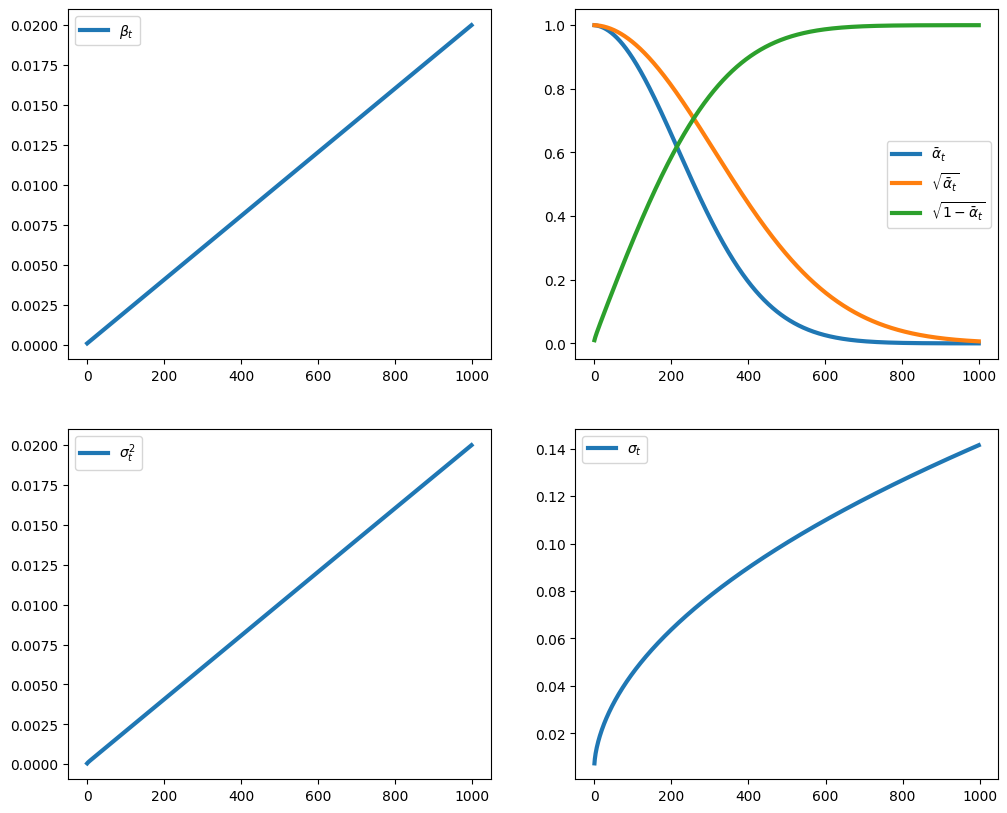

In [4]:
import matplotlib.pyplot as plt
import numpy as np

dp = DiffusionProcess(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02
)

# visualizze betas, alphas, alpha_bars...
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
axes[0].plot(dp.betas.numpy(), lw=3, label=r'$\beta_t$')
#axes[1].plot(dp.alphas.numpy(), lw=3, label=r'$\alpha_t$')
axes[1].plot(dp.alpha_bars.numpy(), lw=3, label=r'$\bar{\alpha}_t$')
axes[1].plot(dp.sqrt_alpha_bars.numpy(), lw=3, label=r'$\sqrt{\bar{\alpha}_t}$')
axes[1].plot(dp.sqrt_one_minus_alpha_bars.numpy(), lw=3, label=r'$\sqrt{1 - \bar{\alpha}_t}$')

variance = dp.betas[1:] * (1 - dp.alpha_bars[:-1]) / (1 - dp.alpha_bars[1:])
sigma = torch.sqrt(variance)
axes[2].plot(variance.numpy(), lw=3, label=r'$\sigma_t^2$')
axes[3].plot(sigma.numpy(), lw=3, label=r'$\sigma_t$')
for ax in axes:
    ax.legend()

# UNet

## Time Embedding
 * Sinusoidal position embedding
 * MLP projection

$$PE(t, 2i)=\sin\left(\frac{t}{10000^{2i/d_{emb}}}\right)$$

$$PE(t, 2i+1)=\cos\left(\frac{t}{10000^{2i/d_{emb}}}\right)$$

torch.Size([1000, 64])
torch.Size([1000, 128])


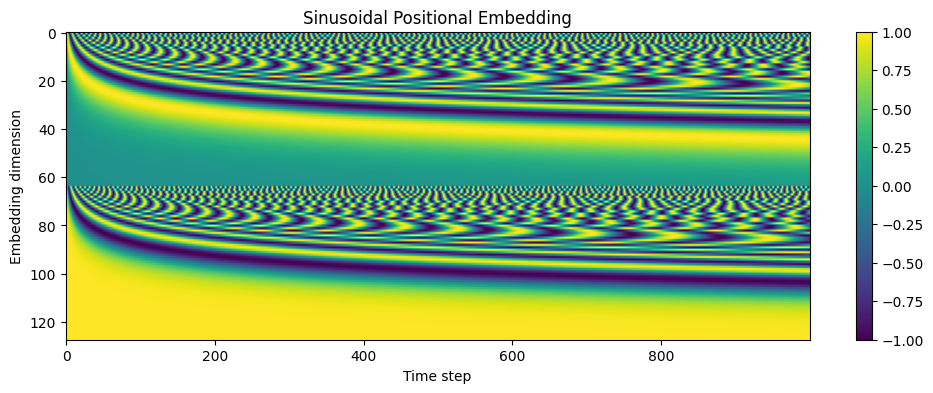

In [18]:
def build_sinusoidal_embedding(num_steps, d_embed, theta, device):
    time_steps = torch.arange(num_steps, device=device)
    half_dim = d_embed // 2
    emb = torch.log(torch.tensor(theta)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = time_steps[:, None] * emb[None, :]
    print(emb.shape)
    emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
    return emb

import matplotlib.pyplot as plt
import numpy as np
pe = build_sinusoidal_embedding(
    1000, 128, 10000, "cpu"
)
print(pe.shape)
plt.figure(figsize=(12, 4))
plt.imshow(pe.T, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Sinusoidal Positional Embedding")
plt.xlabel("Time step")
plt.ylabel("Embedding dimension")
plt.show()

In [15]:
# pre-compute embeddings
pre_computed_embeddings = build_sinusoidal_embedding(
    1000, 128, 10000, "cpu"
)
# test pre-computed embeddings
t = torch.randint(0, 1000, (16,))
pre_computed_embeddings[t].shape

torch.Size([1000, 64])


torch.Size([16, 128])

In [20]:
class TimeEmbeddingProjection(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

        # Pre-compute sinusoidal embeddings
        sinusoidal_emb = build_sinusoidal_embedding(
            1000, embedding_dim, 10000, "cpu"
        )
        self.register_buffer("precomputed_embeddings", sinusoidal_emb)

        # Two-layer MLP to project the time embedding
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.SiLU(),  # SiLU activation (aka Swish)
            nn.Linear(embedding_dim * 4, embedding_dim)
        )
    
    def forward(self, t):
        emb = self.precomputed_embeddings[t]
        return self.mlp(emb)

# testing
t = torch.randint(0, 1000, (16,))
te_proj = TimeEmbeddingProjection(128)
print(te_proj)
out = te_proj(t)
print(f"Input shape: {t.shape}")
print(f"Output shape: {out.shape}")


torch.Size([1000, 64])
TimeEmbeddingProjection(
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
)
Input shape: torch.Size([16])
Output shape: torch.Size([16, 128])


## Residual Block

In [21]:
class ResidualBlock(nn.Module):
    """
    1. GroupNorm -> SiLU -> Conv2d
    2. Inject time embedding (projected to out_channels)
    3. GroupNorm -> SiLU -> Conv2d
    4. (optional) apply a shortcut if in_channels != out_channels
    """
    def __init__(
            self,
            in_channels,
            out_channels,
            time_emb_dim,
            groups=32
        ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # First normalization, activation, conv
        self.norm1 = nn.GroupNorm(groups, in_channels)
        self.activation1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        # Time embedding projection
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)

        # Second normalization, activation, conv
        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.activation2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Shortcut if needed
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t_emb):
        # First block
        h = self.norm1(x)
        h = self.activation1(h)
        h = self.conv1(h)

        # Inject time embedding
        t_emb_proj = self.time_emb_proj(t_emb)  # BxCh_out
        h = h + t_emb_proj[:, :, None, None]  # expand to BxCh_outxHxW

        # Second block
        h = self.norm2(h)
        h = self.activation2(h)
        h = self.conv2(h)

        # Residual connection
        return h + self.shortcut(x)

# testing
batch_size = 4
x = torch.randn(batch_size, 64, 32, 32)
t = torch.randint(0, 1000, (batch_size,))
t_emb = pre_computed_embeddings[t]  # BxCh_out

block = ResidualBlock(
    in_channels=64, out_channels=128, time_emb_dim=128
)
print(block)
out = block(x, t_emb)
print(out.shape)  # Should print torch.Size([4, 128, 32, 32])


ResidualBlock(
  (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (activation1): SiLU()
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb_proj): Linear(in_features=128, out_features=128, bias=True)
  (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
  (activation2): SiLU()
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
)
torch.Size([4, 128, 32, 32])


## Self-Attention Block

* Applited to mid-resolution ($16\times 16$)

In [24]:
class SelfAttentionBlock(nn.Module):
    """
    1. GroupNorm
    2. Reshape to HWxBxC
    3. Apply MultiheadAttention
    4. Reshape back to BxCxHxW
    5. Residual connection
    """
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        
        self.norm = nn.GroupNorm(32, channels)
        
        # nn.MultiheadAttention expects (seq_len, batch, embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            batch_first=False
        )
        
        # Output projection (they usually have a 1x1 conv after attention)
        self.proj_out = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_in = x

        # GroupNorm
        x = self.norm(x)

        # Reshape to (HW, B, C)
        x = x.view(B, C, H * W)  # (B, C, HW)
        x = x.permute(2, 0, 1)   # (HW, B, C)

        # Apply multihead attention
        attn_out, _ = self.attn(x, x, x)  # Self-attention

        # Project output
        attn_out = attn_out.permute(1, 2, 0)  # (B, C, HW)
        attn_out = self.proj_out(attn_out)    # Apply 1x1 conv over channels

        # Reshape back to (B, C, H, W)
        attn_out = attn_out.view(B, C, H, W)

        # Residual connection
        return x_in + attn_out

# testing
batch_size = 4
x = torch.randn(batch_size, 128, 16, 16)
block = SelfAttentionBlock(channels=128, num_heads=4)
print(block)
out = block(x)
print(out.shape)


SelfAttentionBlock(
  (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (proj_out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
)
torch.Size([4, 128, 16, 16])


## UNet architecture

| Block | Components |
|--|--|
| Down Block | Residual Blocks + (optional) Attention + Downsample |
| Mid Block | Residual Blocks + Attention |
| Up Block | Residual Blocks + (optional) Attention + Upsample |

### Downsample & DownBlock

In [26]:
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # 3x3 conv with stride=2
        self.conv = nn.Conv2d(
            channels, channels,
            kernel_size=3,
            stride=2,
            padding=1
        )

    def forward(self, x):
        return self.conv(x)
    
# testing
batch_size = 4
x = torch.randn(batch_size, 128, 32, 32)
downsample = Downsample(channels=128)
print(downsample)
out = downsample(x)
print(out.shape)

Downsample(
  (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
torch.Size([4, 128, 16, 16])


In [27]:
class DownBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            time_emb_dim,
            use_attention=False
        ):
        super().__init__()
        self.res1 = ResidualBlock(
            in_channels, out_channels, time_emb_dim
        )
        self.res2 = ResidualBlock(
            out_channels, out_channels, time_emb_dim
        )
        self.use_attention = use_attention
        if use_attention:
            self.attn = SelfAttentionBlock(
                out_channels, num_heads=1  # 1 head like DDPM
            )
        else:
            self.attn = nn.Identity()
        self.downsample = Downsample(out_channels)

    def forward(self, x, t_emb):
        x = self.res1(x, t_emb)
        x = self.res2(x, t_emb)
        x = self.attn(x)
        skip = x  # Save for skip connection
        x = self.downsample(x)
        return x, skip

# testing
batch_size = 4
x = torch.randn(batch_size, 128, 32, 32)
t = torch.randint(0, 1000, (batch_size,))
t_emb = pre_computed_embeddings[t]  # BxCh_out
down_block = DownBlock(
    in_channels=128, out_channels=256, time_emb_dim=128, use_attention=True
)
print(down_block)
out, skip = down_block(x, t_emb)
print(out.shape)

DownBlock(
  (res1): ResidualBlock(
    (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
    (activation1): SiLU()
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=128, out_features=256, bias=True)
    (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
    (activation2): SiLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (shortcut): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (res2): ResidualBlock(
    (norm1): GroupNorm(32, 256, eps=1e-05, affine=True)
    (activation1): SiLU()
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=128, out_features=256, bias=True)
    (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
    (activation2): SiLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (shortcut): Identity()
  )
  (attn): SelfAttentionBlock(
    (n

### MidBlock

In [28]:
class MidBlock(nn.Module):
    def __init__(self, channels, time_emb_dim):
        super().__init__()
        self.res1 = ResidualBlock(channels, channels, time_emb_dim)
        self.attn = SelfAttentionBlock(channels, num_heads=1)  # 1 head like DDPM
        self.res2 = ResidualBlock(channels, channels, time_emb_dim)

    def forward(self, x, t_emb):
        x = self.res1(x, t_emb)
        x = self.attn(x)
        x = self.res2(x, t_emb)
        return x

# testing
batch_size = 4
x = torch.randn(batch_size, 256, 16, 16)
t = torch.randint(0, 1000, (batch_size,))
t_emb = pre_computed_embeddings[t]  # BxCh_out
mid_block = MidBlock(channels=256, time_emb_dim=128)
print(mid_block)
out = mid_block(x, t_emb)
print(out.shape)

MidBlock(
  (res1): ResidualBlock(
    (norm1): GroupNorm(32, 256, eps=1e-05, affine=True)
    (activation1): SiLU()
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=128, out_features=256, bias=True)
    (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
    (activation2): SiLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (shortcut): Identity()
  )
  (attn): SelfAttentionBlock(
    (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (proj_out): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
  )
  (res2): ResidualBlock(
    (norm1): GroupNorm(32, 256, eps=1e-05, affine=True)
    (activation1): SiLU()
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=128, out_features=2

### Upsample & UpBlock

In [29]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(
            channels, channels,
            kernel_size=3, padding=1
        )

    def forward(self, x):
        x = nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest"
        )
        x = self.conv(x)
        return x

# testing
batch_size = 4
x = torch.randn(batch_size, 256, 16, 16)
upsample = Upsample(channels=256)
print(upsample)
out = upsample(x)
print(out.shape)

Upsample(
  (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([4, 256, 32, 32])


In [31]:
class UpBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            time_emb_dim,
            use_attention=False
        ):
        super().__init__()
        self.upsample = Upsample(in_channels)
        self.res1 = ResidualBlock(
            in_channels + out_channels,
            out_channels, time_emb_dim
        )
        self.res2 = ResidualBlock(
            out_channels, out_channels, time_emb_dim
        )
        self.use_attention = use_attention
        if use_attention:
            self.attn = SelfAttentionBlock(out_channels, num_heads=1)
        else:
            self.attn = nn.Identity()

    def forward(self, x, skip, t_emb):
        x = self.upsample(x)
        x = torch.cat((x, skip), dim=1)
        x = self.res1(x, t_emb)
        x = self.res2(x, t_emb)
        x = self.attn(x)
        return x

# testing
batch_size = 4
x = torch.randn(batch_size, 256, 16, 16)
t = torch.randint(0, 1000, (batch_size,))
t_emb = pre_computed_embeddings[t]  # BxCh_out
skip = torch.randn(batch_size, 128, 32, 32)
up_block = UpBlock(
    in_channels=256, out_channels=128,
    time_emb_dim=128, use_attention=True
)
print(up_block)
out = up_block(x, skip, t_emb)
print(out.shape)

UpBlock(
  (upsample): Upsample(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res1): ResidualBlock(
    (norm1): GroupNorm(32, 384, eps=1e-05, affine=True)
    (activation1): SiLU()
    (conv1): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=128, out_features=128, bias=True)
    (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
    (activation2): SiLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (shortcut): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (res2): ResidualBlock(
    (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
    (activation1): SiLU()
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=128, out_features=128, bias=True)
    (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
    (activation2): SiLU()
    (conv2): Conv2d(128, 128, kernel_size=

## Putting everything togther 

 * Build UNet
 * Initialization:
   * Internal layers use standard Kaiming initialization
   * The lasy conv-layer initialized to zero

In [ ]:
class UNet(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 base_channels=128, 
                 channel_mults=(1, 2, 4, 4),
                 num_res_blocks=2,
                 time_emb_dim=512,
                 attn_resolutions=(16,)):
        """
        Args:
            in_channels: Number of input channels (e.g., 3 for RGB)
            base_channels: Base number of channels (default 128)
            channel_mults: Multipliers for channels at each downsample step
            num_res_blocks: Number of residual blocks per level
            time_emb_dim: Time embedding dimension
            attn_resolutions: Which resolutions to apply attention at (e.g., 16x16)
        """
        super().__init__()

        self.time_embedding = TimeEmbeddingProjection(
            embedding_dim=base_channels
        )

        # Initial input convolution
        self.input_conv = nn.Conv2d(
            in_channels, base_channels,
            kernel_size=3, padding=1
        )

        # Downsampling
        channels = [base_channels]
        in_ch = base_channels
        self.down_blocks = nn.ModuleList()
        resolution = 128

        for mult in channel_mults:
            out_ch = base_channels * mult
            use_attn = resolution in attn_resolutions
            down_block = DownBlock(
                in_ch, out_ch, time_emb_dim, use_attention=use_attn
            )
            self.down_blocks.append(down_block)
            channels.append(out_ch)
            in_ch = out_ch
            resolution //= 2

        # MidBlock (bottom)
        self.mid_block = MidBlock(in_ch, time_emb_dim)

        # Upsampling
        self.up_blocks = nn.ModuleList()
        for mult in reversed(channel_mults):
            out_ch = base_channels * mult
            use_attn = resolution in attn_resolutions
            up_block = UpBlock(
                in_ch, out_ch, time_emb_dim, use_attention=use_attn
            )
            self.up_blocks.append(up_block)
            in_ch = out_ch
            resolution *= 2

        # Final output conv
        self.output_norm = nn.GroupNorm(32, base_channels)
        self.output_act = nn.SiLU()
        self.output_conv = nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        # Zero initialize the final conv layer
        nn.init.zeros_(self.output_conv.weight)
        nn.init.zeros_(self.output_conv.bias)

    def forward(self, x, t):
        """
        Args:
            x: (batch, in_channels, H, W)
            t: (batch,) timesteps
        """
        # Embed time
        t_emb = self.time_embedding(t)

        # Initial conv
        x = self.input_conv(x)

        # Down path
        skips = []
        for down in self.down_blocks:
            x, skip = down(x, t_emb)
            skips.append(skip)

        # Mid block
        x = self.mid_block(x, t_emb)

        # Up path
        for up in self.up_blocks:
            skip = skips.pop()
            x = up(x, skip, t_emb)

        # Final output
        x = self.output_norm(x)
        x = self.output_act(x)
        x = self.output_conv(x)
        return x


In [34]:
# testing
batch_size = 4
x = torch.randn(batch_size, 3, 128, 128)
t = torch.randint(0, 1000, (batch_size,))
unet = UNet(
    in_channels=3,
    base_channels=128,
    channel_mults=(1, 2, 4, 4),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=(16,)
)
#print(unet)
out = unet(x, t)
print(out.shape)

torch.Size([1000, 64])
torch.Size([4, 3, 128, 128])
